## Image Classification of Australian Animals

William Li z5257749

The goal of the project is to create a model that can classify a selection of Australian animals. There are 8 animals, with 200 total images of each:
- Cockatoo
- Dingo
- Kangaroo
- Koala
- Kookaburra
- Platypus
- Seadragon
- Wombat

Images were collected from Google Images with the help of the Image Downloader extension. Images were selected manually to ensure accuracy and avoid duplicates (though I can't guarantee the latter as it's impossible to remember 200 images)

### Import packages and set seed

In [46]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers import AveragePooling2D

In [3]:
tf.keras.utils.set_random_seed(126)

### Data loading and preprocessing

Data is located in the "Data" folder, with images of each animal being in a different subfolder.

The two methods of resizing data are:
- Resizing (changes aspect ratio)
- Resizing with padding (keeps aspect ratio the same, fills the space black to make resulting image square)

A separate array is kept for each method, and both methods will be experimented with later.

In [4]:
labels = []
data_resized = []
data_padded = []

folder_list = os.listdir("Data")
folder_list.sort()
for folder_name in folder_list:
    folder_path = os.path.join("Data", folder_name)
    
    # There are some system files that are not directories
    if not os.path.isdir(folder_path):
        continue
        
    file_list = os.listdir(folder_path)
    file_list.sort()
    for file_name in file_list:
        if file_name.endswith('.jpeg'):
            file_path = os.path.join(folder_path, file_name)
            img = load_img(file_path)
            img_array = img_to_array(img)
            #normalise inputs from [0, 255] to [0, 1]
            img_array /= 255
            
            img_resized = tf.image.resize(img_array, (128, 128))
            data_resized.append(img_resized)
            
            img_padded = tf.image.resize_with_pad(img_array, 128, 128)
            data_padded.append(img_padded)
            
            labels.append(folder_name)
        

In [6]:
data_resized = np.array(data_resized)
data_padded = np.array(data_padded)
labels = np.array(labels)

enc = OneHotEncoder(sparse=False)
labels_oh = enc.fit_transform(labels.reshape(-1,1))

6

The images below shows difference between resizing and resizing with padding

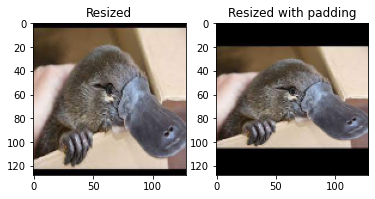

In [8]:
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(data_resized[601])
ax1.set_title("Resized")
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(data_padded[601])
ax2.set_title("Resized with padding")
plt.show()

train_test_split used 3 times to segment data into 4 sets. Their purpose and number of examples per class are:
- Training (96)
- Validation for early-stopping (32)
- Validation for hyperparameter tuning (32) and
- Test (40)

Validation set for early-stopping explicitly defined here rather than using validation_split in model.train as stratify is only available here.

In [15]:
X_train_val_resized, X_test_resized, X_train_val_padded, X_test_padded, y_train_val, y_test =\
train_test_split(data_resized, data_padded, labels_oh, test_size=0.2,
                 shuffle=True, random_state=126, stratify=labels)

X_train_es_resized, X_val_resized, X_train_es_padded, X_val_padded, y_train_es, y_val=\
train_test_split(X_train_val_resized, X_train_val_padded, y_train_val, test_size=0.2,
                 shuffle=True, random_state=126, stratify=y_train_val)

X_train_resized, X_es_resized, X_train_padded, X_es_padded, y_train, y_es=\
train_test_split(X_train_es_resized, X_train_es_padded, y_train_es, test_size=0.25,
                 shuffle=True, random_state=126, stratify=y_train_es)

### Simple model: Logistic regression

In [77]:
#Logistic regression doesn't need validation for early stopping, can include it for training
X_train_es = X_train_es_padded
X_val = X_val_padded

#128x128 RGB has too many features for logistic regression, so resize 8x8 so there are 8*8*3=192 features
X_train_es_small = []
for image in X_train_es:
    X_train_es_small.append(tf.image.resize(image, (8, 8)))
X_train_es_small = np.array(X_train_es_small)

X_val_small = []
for image in X_val:
    X_val_small.append(tf.image.resize(image, (8, 8)))
X_val_small = np.array(X_val_small)

X_train_es_flat = X_train_es_small.reshape(X_train_es.shape[0], -1)
X_val_flat = X_val_small.reshape(X_val.shape[0], -1)
y_train_es_1d = np.argmax(y_train_es, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

num_classes = y_train_es.shape[1]

lr_model = LogisticRegression()
lr_model.fit(X_train_es_flat, y_train_es_1d)
y_val_pred = lr_model.predict(X_val_flat)

/Users/williamli/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
correct=np.equal(y_val_pred, y_val_1d)
correct

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
       False,  True,  True, False,  True,  True, False,  True,  True,
       False, False,  True,  True, False,  True,  True, False, False,
       False, False,  True,  True,  True, False,  True, False,  True,
        True, False,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False,  True, False,  True, False,
       False, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True, False, False,  True, False,
       False, False, False,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
        True, False,

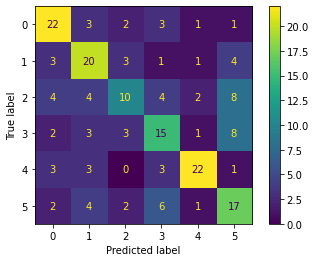

In [79]:
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred)

In [59]:
X_train_es_flat.shape

(768, 192)

In [80]:
np.mean(correct)

0.5520833333333334